/tmp/ipykernel_257992/1983513864.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


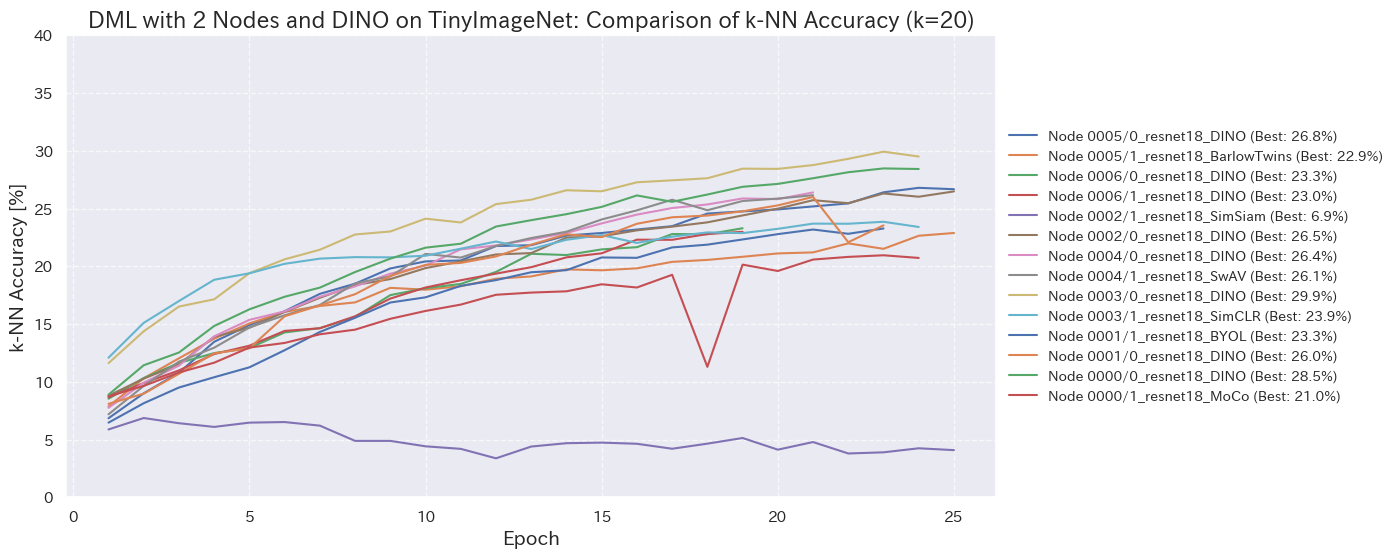

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
import os


def extract_scalar_arrays(scalar_events):
    wall_times, steps, values = [], [], []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)


def plot_results(logs_dir, scalar_tag, title, xlabel, ylabel, ylim):
    plt.style.use("seaborn-darkgrid")
    sns.set(font="IPAexGothic")
    fig, ax = plt.subplots(figsize=(12, 6))
    best_accuracy = 0  # 最高の k-NN 精度を保持する変数

    # パスと最高精度のディクショナリを作成
    accuracy_dict = {}

    for node_dir in os.listdir(logs_dir):
        node_path = os.path.join(logs_dir, node_dir)
        if not os.path.isdir(node_path):
            continue

        for index, event_file in enumerate(
            glob(os.path.join(node_path, "*_resnet18_*/events.out.tfevents.*"))
        ):
            accumulator = EventAccumulator(event_file)
            accumulator.Reload()
            wall_times, steps, values = extract_scalar_arrays(
                accumulator.Scalars(scalar_tag)
            )

            # 最高精度を取得
            max_accuracy = np.max(values)
            accuracy_dict[node_dir] = max_accuracy

            # グラフと凡例を描画
            ax.plot(
                steps,
                values,
                label=f"Node {node_dir}/{event_file.split('/')[-2]} (Best: {max_accuracy:.1f}%)",
            )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_ylim(*ylim)
    ax.grid(True, linestyle="--", alpha=0.7)

    # 凡例を右に配置
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.show()


if __name__ == "__main__":
    logs_dir = "runs/dml_2_DINO/DINO"
    plot_results(
        logs_dir,
        scalar_tag="test_top1",
        title="DML with 2 Nodes and DINO on TinyImageNet: Comparison of k-NN Accuracy (k=20)",
        xlabel="Epoch",
        ylabel="k-NN Accuracy [%]",
        ylim=(0, 40),
    )